In [1]:
from __future__ import print_function
import os
import neat

import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


from explaneat.core.backprop import NeatNet
from explaneat.core import backprop
from explaneat.core.backproppop import BackpropPopulation
from explaneat.visualization import visualize
from explaneat.core.experiment import ExperimentReporter
from explaneat.core.utility import one_hot_encode


from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from copy import deepcopy

import time
from datetime import datetime


import gzip
try:
    import cPickle as pickle  # pylint: disable=import-error
except ImportError:
    import pickle  # pylint: disable=import-error

In [2]:

USE_CUDA = torch.cuda.is_available()
# USE_CUDA = False
device = torch.device("cuda:1" if USE_CUDA else "cpu")


# Breast Cancer Experiment

This experiment (a) test the experimental environment, but is also to evaluate the efficacy of the ExplaNEAT algorithm. Speed is a critical factor, as well as stability of results on population size. Total run time will also be measured

First, we need to set a random seed and a total stopping point in the number of generations

In [3]:
my_random_seed = 42
random.seed(my_random_seed)

In [4]:
def one_hot_encode(vals):
    width = max(vals)
    newVals = []
    for val in vals:
        blank = [0. for _ in range(width + 1)]
        blank[val] = 1.
        newVals.append(blank)
    return np.asarray(newVals)


## Dataset

We are going to work with the Iris dataset, which will be loaded from `sklearn`. We want to characterise the efficacy of the algorithm with regards to a mostly untransformed dataset, so we will only normalise the features

In [5]:
def load_dataset(fp, 
                 randomSeed = 42, 
                 proportionValidation = 0.2):
    ''' Takes in a filepath, returns x_train, x_validate, y_train, y_validate'''
    df = pd.read_csv(fp).reset_index(drop=True)
    xs_raw = df[[
        'ag_age',
        'ag_sex',
        'ag_eth',
        'pt_nzdep',
        'imp_hxdiab',
        'pt_tc_hdl_ratio',
        'pt_bps',
        'pt_bpd',
        'pt_smoke',
        'imp_hxcvd',
        'imp_hdl',
        'imp_ldl',
        'imp_tchol',
        'marker',
        'region',
        'PH_BL_LLD_ANY',
        'PH_BL_AHT_ANY',
        'pt_familyhistory',
        'ab_gen',
        'eth_gen',
        'is.female',
        'log.age',
        'log.age.gender',
        'log.sbp',
        'smoking',
        'log.tchdl',
        'diabetes',
        'diabetes.sex']]
    
    xs_raw = xs_raw[[
        'is.female', 
        'ag_age',
        'pt_bps',
        'smoking',
        'pt_tc_hdl_ratio',
        'diabetes'
    ]]


    scaler = StandardScaler()
    
    scaler.fit(xs_raw)
    xs = scaler.transform(xs_raw)
    ys = df['dead'].apply(lambda x: 1 if x else 0)
    ys = np.array(ys).astype(float)
    if proportionValidation == 0:
        return xs, [], ys, []
    X_train, X_validate, y_train, y_validate = train_test_split(xs, ys, test_size=proportionValidation, random_state=randomSeed)
    return X_train, X_validate, y_train, y_validate
    


In [6]:
X_test, _, y_test, __ = load_dataset('./../../data/processed/synthetic_view/synthetic_view_test.csv')

In [7]:
X_test[:5]

array([[-1.04660448, -0.79372918, -0.82597264, -0.86593193, -2.14787211,
        -0.3018414 ],
       [-1.04660448, -1.54731757,  0.1902044 ,  1.15482518, -0.0411511 ,
        -0.3018414 ],
       [-1.04660448,  0.51355442,  0.03688167,  1.15482518, -0.10389362,
        -0.3018414 ],
       [ 0.95547078, -0.86687438, -1.44050974, -0.86593193, -0.10620131,
        -0.3018414 ],
       [ 0.95547078,  0.99632167, -0.82704809, -0.86593193, -0.8058885 ,
        -0.3018414 ]])

In [8]:
y_test[:5]

array([0., 0., 0., 0., 0.])

## Performance metric

The NEAT implementation on which ExplaNEAT extends uses a single function call for evaluating fitness. Although this might be reworked for ExplaNEAT to be able to get consistency between the genome-evaluation and the backprop loss function, that can be reviewed later.

This use `Binary Cross Entropy Loss` from `PyTorch`

In [ ]:
# def eval_genomes(genomes, config):
#     loss = nn.BCELoss()
#     loss = loss.to(device)
#     for genome_id, genome in genomes:
#         net = neat.nn.FeedForwardNetwork.create(genome, config)
#         preds = []
#         for xi in X_validate:
#             preds.append(1. if net.activate(xi)[0] > 0.5 else 0.)
#         correct = 0
#         for pred, truth in zip(preds, y_validate):
#             if pred == truth:
#                 correct += 1.
        
        
#         genome.fitness = float(correct / len(preds))
def eval_genomes(genomes, config):
    loss = nn.BCEWithLogitsLoss()
    loss = loss.to(device)
    for genome_id, genome in genomes:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        preds = []
        for xi in X_validate:
            preds.append(net.activate(xi))
        genome.fitness = float(1./loss(torch.tensor(preds), torch.tensor(y_validate)))

## Create a neural network


In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_width=64):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_width) 
        self.fc2 = nn.Linear(hidden_width, hidden_width)
        self.fc3 = nn.Linear(hidden_width, hidden_width)
        self.fc4 = nn.Linear(hidden_width, hidden_width)
        self.fc5 = nn.Linear(hidden_width, output_size)  
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out

## Base configuration

We also want to put a hard limit on how long this can go on for.

In [ ]:
nIterations = 5
nEpochs = 1000

# Experiment: Vary dataset size

The first experiment is going to examine the difference from different dataset sizess

In [ ]:
datasetSizes = [
        1000,
        2500,
        5000,
        10000,
        25000,
        50000,
        100000,
        250000,
#         500000,
#         1000000,
#         1500000,
#         2000000
    ]
# datasetSizes = [1000]

In [ ]:
saveLocationTemplate = './../../data/experiments/synthview-nn/experiment-dataset-{}-{}/'

In [ ]:
datasetLocation = './../../data/processed/synthetic_view/'
datasetFileTemplate = 'synthetic_view_test_{:07d}.csv'
# os.path.join(output_filepath, 'synthetic_view_test_{:07d}.csv'.format(dsSize)))

## Start the experiment

In [ ]:
batch_size = 500
learning_rate = 0.0005
num_epochs = 5000

In [ ]:
class TabularDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, xs, ys):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return (x, y)


In [ ]:
for dsSize in datasetSizes:
    for iteration_no in range(5):
        
        X_train, X_validate, y_train, y_validate = load_dataset(os.path.join(datasetLocation, datasetFileTemplate.format(dsSize)))
        X_train = torch.tensor(X_train).float()
        X_validate = torch.tensor(X_validate).float()
        y_train = torch.tensor(y_train).float()
        y_validate = torch.tensor(y_validate).float()
        
        train_data = TabularDataset(X_train, y_train)
        train_loader = DataLoader(train_data, 
                                   batch_size=batch_size, 
                                   shuffle=True)
        
        validate_data = TabularDataset(X_validate, y_validate)
        validate_loader = DataLoader(dataset = validate_data,
                                     batch_size=batch_size, 
                                     shuffle=False)
        
        total_step = len(train_loader)

        saveLocation = saveLocationTemplate.format(dsSize, iteration_no)


        my_random_seed += 1
        random.seed(my_random_seed)
        start_time = datetime.now()
        
        
        model = NeuralNet(6, 1).to(device)

        # Loss and optimizer
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

        # Train the model
        for epoch in range(num_epochs):
            for i, (xs, ys) in enumerate(train_loader):  
                # Move tensors to the configured device
                xs = xs.to(device)
                ys = ys.view(-1, 1).to(device)
                
                # Forward pass
                outputs = model(xs)
                loss = criterion(outputs, ys)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (epoch+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                
#         with torch.no_grad():
#             correct = 0
#             total = 0
#             for xs, ys in test_loader:
#                 xs = xs.to(device)
#                 ys = ys.view(-1, 1).to(device)
#                 outputs = model(xs)
#                 _, predicted = torch.round(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == ys).sum().item()
        if not os.path.exists(saveLocation):
            os.makedirs(saveLocation)
        torch.save(model.state_dict(), os.path.join(saveLocation,'model.ckpt'))

        end_time = datetime.now()

        print("################################################")
        print("################################################")
        print("Have finished dsSize {} iteration {}".format(dsSize, iteration_no))
        print("Started at {}".format(start_time.strftime("%m/%d/%Y, %H:%M:%S")))
        print("The time is {}".format(end_time.strftime("%m/%d/%Y, %H:%M:%S")))
        print("################################################")
        print("################################################")
    

Epoch [100/5000], Step [2/2], Loss: 0.2909
Epoch [200/5000], Step [2/2], Loss: 0.2763
Epoch [300/5000], Step [2/2], Loss: 0.2294
Epoch [400/5000], Step [2/2], Loss: 0.2511
Epoch [500/5000], Step [2/2], Loss: 0.2378
Epoch [600/5000], Step [2/2], Loss: 0.2131
Epoch [700/5000], Step [2/2], Loss: 0.2053
Epoch [800/5000], Step [2/2], Loss: 0.2419
Epoch [900/5000], Step [2/2], Loss: 0.2692
Epoch [1000/5000], Step [2/2], Loss: 0.1669
Epoch [1100/5000], Step [2/2], Loss: 0.2014
Epoch [1200/5000], Step [2/2], Loss: 0.1745
Epoch [1300/5000], Step [2/2], Loss: 0.2084
Epoch [1400/5000], Step [2/2], Loss: 0.1708
Epoch [1500/5000], Step [2/2], Loss: 0.1888
Epoch [1600/5000], Step [2/2], Loss: 0.1962
Epoch [1700/5000], Step [2/2], Loss: 0.2307
Epoch [1800/5000], Step [2/2], Loss: 0.2168
Epoch [1900/5000], Step [2/2], Loss: 0.1824
Epoch [2000/5000], Step [2/2], Loss: 0.1793
Epoch [2100/5000], Step [2/2], Loss: 0.2040
Epoch [2200/5000], Step [2/2], Loss: 0.1607
Epoch [2300/5000], Step [2/2], Loss: 0.18

Epoch [1800/5000], Step [2/2], Loss: 0.2433
Epoch [1900/5000], Step [2/2], Loss: 0.1630
Epoch [2000/5000], Step [2/2], Loss: 0.2294
Epoch [2100/5000], Step [2/2], Loss: 0.1819
Epoch [2200/5000], Step [2/2], Loss: 0.1690
Epoch [2300/5000], Step [2/2], Loss: 0.2069
Epoch [2400/5000], Step [2/2], Loss: 0.1946
Epoch [2500/5000], Step [2/2], Loss: 0.2003
Epoch [2600/5000], Step [2/2], Loss: 0.1849
Epoch [2700/5000], Step [2/2], Loss: 0.1918
Epoch [2800/5000], Step [2/2], Loss: 0.1442
Epoch [2900/5000], Step [2/2], Loss: 0.1799
Epoch [3000/5000], Step [2/2], Loss: 0.1734
Epoch [3100/5000], Step [2/2], Loss: 0.1694
Epoch [3200/5000], Step [2/2], Loss: 0.1577
Epoch [3300/5000], Step [2/2], Loss: 0.1605
Epoch [3400/5000], Step [2/2], Loss: 0.1940
Epoch [3500/5000], Step [2/2], Loss: 0.1180
Epoch [3600/5000], Step [2/2], Loss: 0.1736
Epoch [3700/5000], Step [2/2], Loss: 0.1382
Epoch [3800/5000], Step [2/2], Loss: 0.1179
Epoch [3900/5000], Step [2/2], Loss: 0.1428
Epoch [4000/5000], Step [2/2], L

Epoch [3500/5000], Step [4/4], Loss: 0.1584
Epoch [3600/5000], Step [4/4], Loss: 0.1652
Epoch [3700/5000], Step [4/4], Loss: 0.1494
Epoch [3800/5000], Step [4/4], Loss: 0.1712
Epoch [3900/5000], Step [4/4], Loss: 0.1777
Epoch [4000/5000], Step [4/4], Loss: 0.1356
Epoch [4100/5000], Step [4/4], Loss: 0.1538
Epoch [4200/5000], Step [4/4], Loss: 0.1651
Epoch [4300/5000], Step [4/4], Loss: 0.1406
Epoch [4400/5000], Step [4/4], Loss: 0.1755
Epoch [4500/5000], Step [4/4], Loss: 0.1506
Epoch [4600/5000], Step [4/4], Loss: 0.1372
Epoch [4700/5000], Step [4/4], Loss: 0.1392
Epoch [4800/5000], Step [4/4], Loss: 0.1619
Epoch [4900/5000], Step [4/4], Loss: 0.1411
Epoch [5000/5000], Step [4/4], Loss: 0.1527
################################################
################################################
Have finished dsSize 2500 iteration 1
Started at 07/28/2019, 23:03:12
The time is 07/28/2019, 23:04:28
################################################
##############################################

Epoch [100/5000], Step [8/8], Loss: 0.1801
Epoch [200/5000], Step [8/8], Loss: 0.2395
Epoch [300/5000], Step [8/8], Loss: 0.2066
Epoch [400/5000], Step [8/8], Loss: 0.2262
Epoch [500/5000], Step [8/8], Loss: 0.2038
Epoch [600/5000], Step [8/8], Loss: 0.2173
Epoch [700/5000], Step [8/8], Loss: 0.2462
Epoch [800/5000], Step [8/8], Loss: 0.2084
Epoch [900/5000], Step [8/8], Loss: 0.1709
Epoch [1000/5000], Step [8/8], Loss: 0.1504
Epoch [1100/5000], Step [8/8], Loss: 0.2061
Epoch [1200/5000], Step [8/8], Loss: 0.1928
Epoch [1300/5000], Step [8/8], Loss: 0.1788
Epoch [1400/5000], Step [8/8], Loss: 0.2363
Epoch [1500/5000], Step [8/8], Loss: 0.2065
Epoch [1600/5000], Step [8/8], Loss: 0.1988
Epoch [1700/5000], Step [8/8], Loss: 0.1906
Epoch [1800/5000], Step [8/8], Loss: 0.2431
Epoch [1900/5000], Step [8/8], Loss: 0.1669
Epoch [2000/5000], Step [8/8], Loss: 0.2048
Epoch [2100/5000], Step [8/8], Loss: 0.1919
Epoch [2200/5000], Step [8/8], Loss: 0.1960
Epoch [2300/5000], Step [8/8], Loss: 0.19

Epoch [1800/5000], Step [8/8], Loss: 0.2003
Epoch [1900/5000], Step [8/8], Loss: 0.1604
Epoch [2000/5000], Step [8/8], Loss: 0.1984
Epoch [2100/5000], Step [8/8], Loss: 0.2161
Epoch [2200/5000], Step [8/8], Loss: 0.2134
Epoch [2300/5000], Step [8/8], Loss: 0.2457
Epoch [2400/5000], Step [8/8], Loss: 0.2196
Epoch [2500/5000], Step [8/8], Loss: 0.2384
Epoch [2600/5000], Step [8/8], Loss: 0.1819
Epoch [2700/5000], Step [8/8], Loss: 0.1798
Epoch [2800/5000], Step [8/8], Loss: 0.1619
Epoch [2900/5000], Step [8/8], Loss: 0.1883
Epoch [3000/5000], Step [8/8], Loss: 0.1793
Epoch [3100/5000], Step [8/8], Loss: 0.1871
Epoch [3200/5000], Step [8/8], Loss: 0.1958
Epoch [3300/5000], Step [8/8], Loss: 0.2151
Epoch [3400/5000], Step [8/8], Loss: 0.1955
Epoch [3500/5000], Step [8/8], Loss: 0.2141
Epoch [3600/5000], Step [8/8], Loss: 0.2135
Epoch [3700/5000], Step [8/8], Loss: 0.1968
Epoch [3800/5000], Step [8/8], Loss: 0.1984
Epoch [3900/5000], Step [8/8], Loss: 0.2316
Epoch [4000/5000], Step [8/8], L

In [18]:
model

NeuralNet(
  (fc1): Linear(in_features=6, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [21]:
outputs

tensor([[-5.3766],
        [-5.3431],
        [-3.4633],
        [-4.0969],
        [-2.0781],
        [-2.6340],
        [-1.3242],
        [-0.7078],
        [-5.3072],
        [-2.8817],
        [-2.7381],
        [-2.6294],
        [-3.9931],
        [-2.7070],
        [-4.2784],
        [-2.4114],
        [-4.9203],
        [-1.5695],
        [-4.0730],
        [-2.7006],
        [-5.5958],
        [-2.9969],
        [-2.4064],
        [-3.5870],
        [-4.2876],
        [-4.1803],
        [-6.1838],
        [-1.6297],
        [-4.2251],
        [-4.9519],
        [-2.7264],
        [-4.9742],
        [-5.4956],
        [-3.4699],
        [-2.3981],
        [-1.8624],
        [-2.0562],
        [-3.7674],
        [-1.2754],
        [-5.6785],
        [-0.4536],
        [-4.1079],
        [-3.4017],
        [-1.9427],
        [-2.9994],
        [-5.6323],
        [-1.5211],
        [-6.1970],
        [-5.8131],
        [-1.7056],
        [-2.5823],
        [-2.9177],
        [-4.

In [24]:
sig = nn.Sigmoid()

In [26]:
sig_out = sig(outputs)

In [41]:
cpuys = ys.cpu().numpy() + 1
cpuout = sig_out.cpu().detach().numpy()

In [42]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(cpuys, cpuout, pos_label=2)
metrics.auc(fpr, tpr)



0.8545115222330413

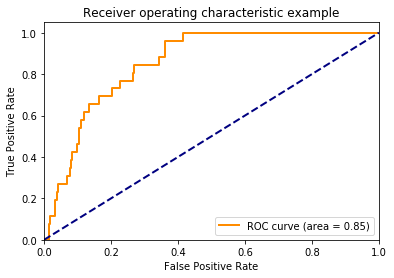

In [46]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()